# The thermal response test


When installing a shallow geothermal system, typically borehole heat exchangers (BHE), it is important to determine *thermal conductivity* as well as possible. A precise characterization of this property allows a correct design of the system, avoiding oversizing or undersizing, respectively, of the system. As we have discussed in the lecture, a **Thermal Response Test (TRT)** allows determining the *in-situ* thermal conductivity. In a normal TRT, the determined value represents a mean value in the area of the borehole.


![](https://raw.githubusercontent.com/darius74/geothermics/master/imgs/sketch_trt_add.jpg)



In principle, during a TRT heat is injected into the ground at a constant rate and the inlet ($T_1$ or $T_{down}$), and outlet temperatures ($T_2$ or $T_{up}$) are recorded, as well as the flow $\dot{V}$ if the carrier fluid. The heat power transferred to the ground can be calculated either from the electrical parameters or by
$$ P= (T_{down}-T_{up})\, \rho c_p\,\dot{V}$$

where $\rho c_p$ is the thermal capacity of the fluid.

In this notebook, we will take a look at data from a (real) thermal response test. The aim is to determine a mean thermal conductivity along the **100 m deep borehole (radius 7.5 cm)**.  
The data comprises inlet temperatures  the outlet temperature, the power, as well as the corresponding times.

First we need to import the libraries and take a look at the data, importing the cvs file:

In [3]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as p
from scipy import optimize
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

data = p.read_csv('data/TRT_data.csv')
data.head(10)

,T1(C),T2(C),Power(W),Time(min)
0,13.47,13.50,0,0
1,13.48,13.50,0,10
2,13.51,13.50,0,20
3,13.54,13.54,0,30
4,13.56,13.56,0,40
5,15.13,13.61,3400,50
6,16.09,14.57,3400,60
7,16.62,15.09,3400,70
8,17.04,15.53,3400,80
9,17.38,15.87,3400,90


Then, we want to plot the inlet and outlet temperature (down and up), as well as the mean temperature $T_{mean}=\frac{T_{down}+T_{up}}{2}$, respectively, in the same figure, using different colors for the different temperatures.

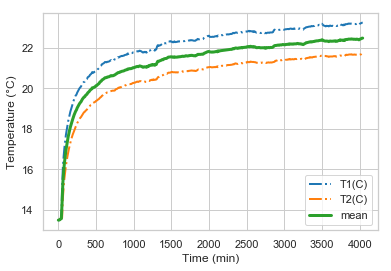

In [6]:
T1=data['T1(C)']
T2=data['T2(C)']
P=data['Power(W)']
t=data['Time(min)']

Tmean=(T1+T2)/2


plt.plot(t,T1,'-.', linewidth=2, label='T1(C)')
plt.plot(t,T2,'-.', linewidth=2, label='T2(C)')
plt.plot(t,Tmean,'-', linewidth=3, label='mean')
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Temperature (°C)')

plt.grid(True)




If we now plot the same temperatures using a logarithmic scale in terms of time, we will be able to determine thermal conductivity $\lambda$ from the slope $m$ of the mean temperature then (see lecture):
$$T_{mean}(t) =  {\color{red}m}\, \ln (t/t_0)+n$$
with $${\color{red}m}=\frac{q_s}{4 \pi \lambda}$$

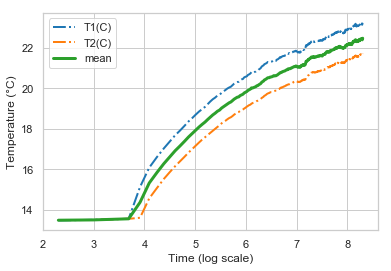

In [5]:
# we only need to change the time-axis, considering that the first entry must be omitted (t=0), therefore we need to adapt the other data too (-1 means last entry)
tlog=np.log(t[1:-1])

T1log=T1[1:-1]
T2log=T2[1:-1]
Tmeanlog=Tmean[1:-1]
# the log scale is now scaled by the used time unit "minute".

# Here is the plot with the logarithmic time scale
plt.plot(tlog,T1log,'-.', linewidth=2, label='T1(C)')
plt.plot(tlog,T2log,'-.', linewidth=2, label='T2(C)')
plt.plot(tlog,Tmeanlog,'-', linewidth=3, label='mean')
plt.legend()
plt.xlabel('Time (log scale)')
plt.ylabel('Temperature (°C)')
plt.grid(True)

Now we need to find a criterion to find a time instance after which the data is suitable for determining thermal conductivity after Kelvin's line source theory. As seen in the lecture, this corresponds to the so called **Fourier number** $Fo$:

$$Fo=\frac{\kappa\, t}{r^2}$$

Here you can use $\kappa=10^{-6}$ m s$^{-2}$ in order to find the time instance for which $Fo=20$. Then you should use only data from this time on. After assigning these values, it is possible to calculate thermal conductivity.

In [7]:
# thermal diffusivity
kappa=1.e-6
# borehole radius
rb=0.075

# For the Fourier-Number we need to calculate time in seconds

Fo=kappa*t*60/rb**2

# Find the index where Fo is greater than 20 and use only values above for all arrays, including the power:

tlinear=t[np.array(Fo)>20]
T1linear=T1[np.array(Fo)>20]
T2linear=T2[np.array(Fo)>20]
Tmeanlinear=Tmean[np.array(Fo)>20]
Powerlinear=P[np.array(Fo)>20]
# Again, we need to claculate the logarithmic time, now scaled by the unit second:

tlinear_log=np.log(tlinear*60)

# Now are able to interpolate the mean temperature in order to find the slope m:
m, b = np.polyfit(tlinear_log, Tmeanlinear, 1) 

# setting up an array for plotting with the determined slope and intersection:

T_regression = tlinear_log*m + b

# the slope m is used for calculating thermal conductivity finally, for this we need the power transferred to the ground per meter:
#(we don't use the term lambda as it is an operator in Python)

qs=np.mean(Powerlinear)/100

tc=qs/(4*np.pi*m)


print("The mean thermal conductitvity is {} W/(m K) "
      .format(np.round(np.abs(tc),2)))


The mean thermal conductitvity is 2.88 W/(m K) 


Finally, we want to plot the linear regression as well as the temperatures:

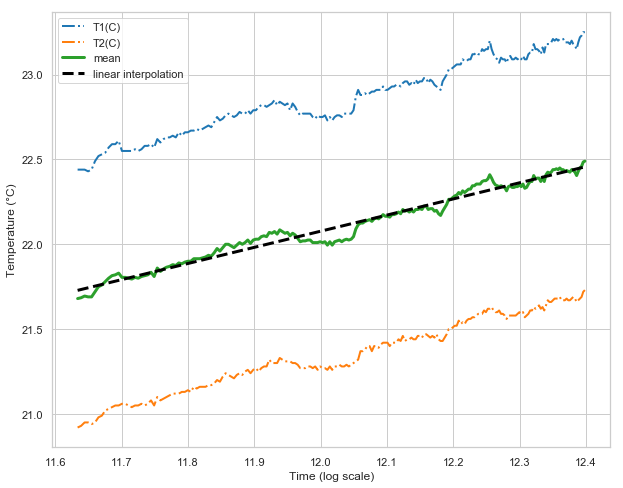

In [10]:
fig = plt.figure(figsize=[10,8])

plt.plot(tlinear_log,T1linear,'-.', linewidth=2, label='T1(C)')
plt.plot(tlinear_log,T2linear,'-.', linewidth=2, label='T2(C)')
plt.plot(tlinear_log,Tmeanlinear,'-', linewidth=3, label='mean')
plt.plot(tlinear_log,T_regression,'--', linewidth=3, 
         color='black', label='linear interpolation')
plt.legend()
plt.xlabel('Time (log scale)')
plt.ylabel('Temperature (°C)')
plt.grid(True)